In [1]:
import torch
import torchvision
import torchvision.utils as vutils

import os
import json
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as TF
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import GuidedBackprop
from captum.attr import Saliency
from captum.attr import InputXGradient


import core.config.configuration as cnfg

from dataset_preparation import classifier_dataset
from core.vae import VAE
import train_vae
import train_classifier
import core.geodesic as gdsc
import core.attributional_attack
import core.attribution_methods as att_mthds
import core.utils as utils
import core.attributional_attack as att_attack
from importlib import reload

/scratch/imb/uqezaher/anaconda3/envs/XAI_BM/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/scratch/imb/uqezaher/anaconda3/envs/XAI_BM/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

In [ ]:
vae_net = train_vae.train()

In [2]:
clf, vae_net = train_classifier.train_clf()

/scratch/imb/uqezaher/anaconda3/envs/XAI_BM/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/imb/uqezaher/anaconda3/envs/XAI_BM/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VAE checkpoint loaded


  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
train_loader, test_loader = classifier_dataset.prepare_data_classifier()

train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)
test_dataiter = iter(test_loader)
test_images, test_labels = next(train_dataiter)


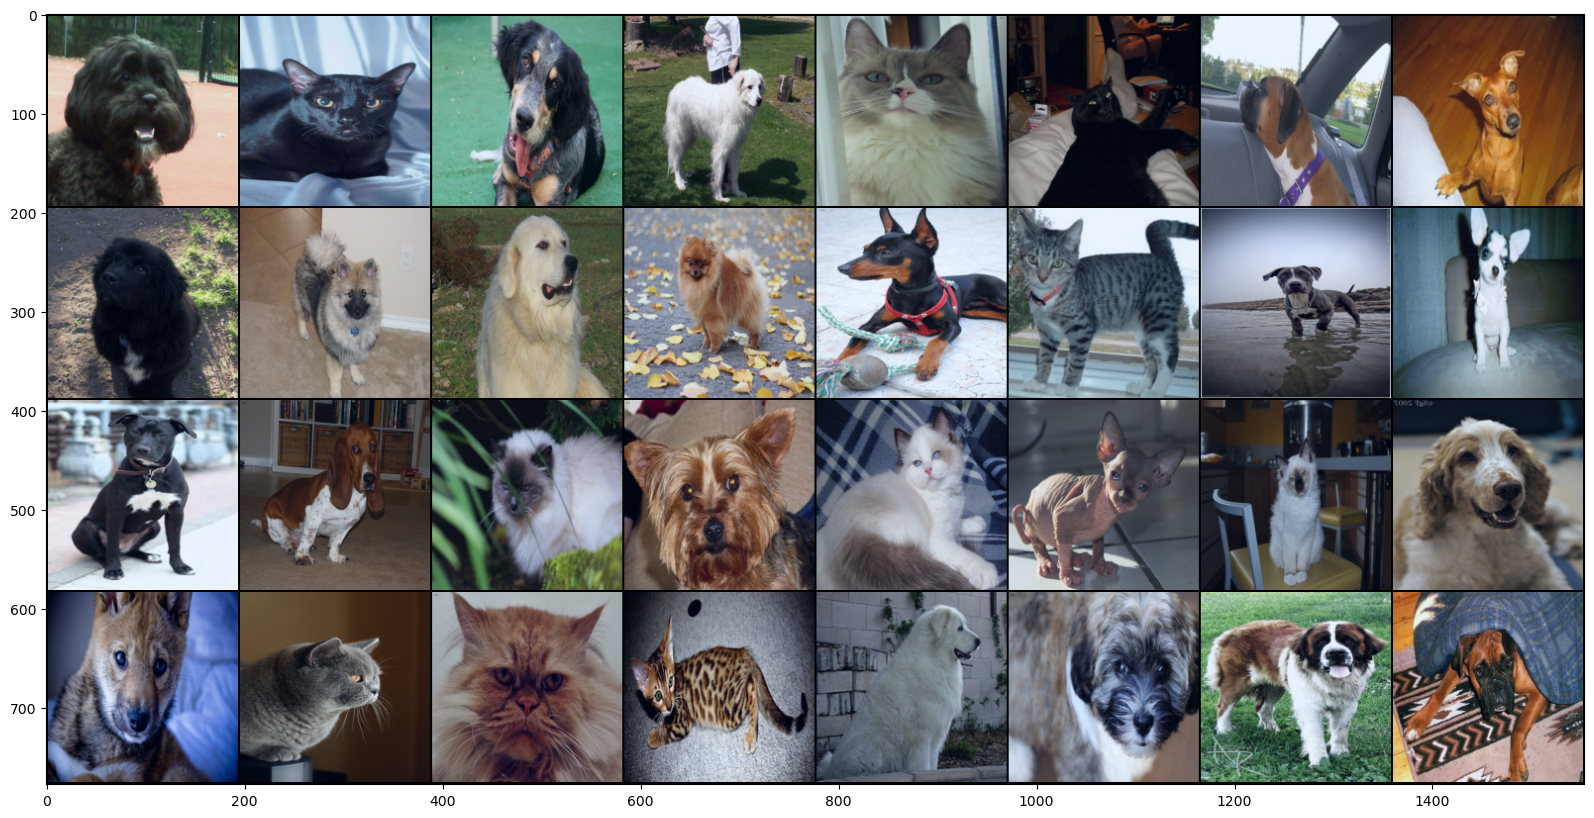

In [4]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(train_images[0:32], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [5]:
vae_net.eval()

black_image = torch.zeros(cnfg.image_size)
black_image = TF.to_pil_image(black_image)


#black_image = black_image.unsqueeze(0)
#black_image = torch.FloatTensor(1,3,128,128).zero_().cuda()
black_image = classifier_dataset.test_transform(black_image)
black_image = black_image.unsqueeze(0).cuda()
black_z,_,_ = vae_net.encoder(black_image)
black_image_rec = vae_net.decoder(black_z)

out = vutils.make_grid(black_image_rec, normalize=True)
plt.imshow(out.cpu().detach().numpy().transpose((1, 2, 0)))


NameError: name 'vae_net' is not defined

In [ ]:
vae_net.eval()

white_image = torch.ones(cnfg.image_size)
white_image = TF.to_pil_image(white_image)

white_image = classifier_dataset.test_transform(white_image)
white_image = white_image.unsqueeze(0)
white_z,_,_ = vae_net.encoder(white_image.cuda())
wl = vae_net.decoder(white_z)


out = vutils.make_grid(wl, normalize=True)
plt.imshow(out.cpu().detach().numpy().transpose((1, 2, 0)))




In [ ]:
ix = 50
im, label = train_images[ix].unsqueeze(0).cuda(), train_labels[ix]

x_z,_,_ =vae_net.encoder(im)
rec_im,_,_ = vae_net(im)

output = clf(rec_im)
_, predictions = torch.max(output.data, 1)
target_class = predictions
print(f"{target_class == label}")

#im = test_images[ix].view(1, cnfg.in_channels, cnfg.image_width, cnfg.image_width).cuda()

z0 = black_z
zf = x_z
z_collection = utils.interpolate(z0, zf, cnfg.num_interpolants) #[z0 + float(i) / T * (zT - z0) for i in range(T)]
#z_collection = [z0 if i == 0 else zT if i == T - 1 else z0 + float(i) / T * (zT - z0) + 0.2 * torch.randn_like(z0) for i in range(T)]

path = gdsc.geodesic_path_algorithm(vae_net, z_collection,alpha=cnfg.default_alpha,
                               T=cnfg.num_interpolants, beta=cnfg.beta,
                               epsilon=cnfg.epsilon,max_iterations=2)

In [ ]:
#geodesic path
interpolated_geodesic_images = [vae_net.decoder(vec) for vec in path]

vv = [v.squeeze() for v in interpolated_geodesic_images]
plt.figure(figsize = (20,10))
out = vutils.make_grid(vv, nrow=len(vv), normalize=False)
plt.xticks([])
plt.yticks([])
plt.imshow(out.cpu().numpy().transpose((1, 2, 0)))

In [ ]:
#linear IG path
zero_baseline = torch.zeros_like(rec_im).cuda()
interpolated_vectors = utils.interpolate(zero_baseline, interpolated_geodesic_images[-1], cnfg.num_interpolants)

vv = [v.squeeze() for v in interpolated_vectors]

plt.figure(figsize = (30,30))
out = vutils.make_grid(vv, nrow=len(vv), normalize=False)
plt.xticks([])
plt.yticks([])
plt.imshow(out.cpu().numpy().transpose((1, 2, 0)))

In [ ]:
#ig = IntegratedGradients(clf)
#ig_map = ig.attribute(rec_im, target=target_class)

#gbp = GuidedBackprop(clf)
#gbp_map = gbp.attribute(rec_im, target=target_class)

#saliency = Saliency(clf)
#saliency_map = saliency.attribute(rec_im, target=target_class)

#x_grad = InputXGradient(clf)
#x_grad_map = x_grad.attribute(rec_im, target=target_class)


#nt = NoiseTunnel(ig)
#smooth_grad = nt.attribute(rec_im, nt_type='smoothgrad', nt_samples=20, target=target_class)

#sm = smoothgrad(rec_im, zero_baseline, 15, tail=0.10)

int_grads_ = att_mthds.integrated_gradients(clf, zero_baseline, rec_im, target_class, steps=cnfg.num_interpolants)
default_cmap = LinearSegmentedColormap.from_list('custom blue',[(0, '#000000'),(0.25, '#ffffff'),(1, '#ffffff')], N=256)

fig, _ = viz.visualize_image_attr(np.transpose(int_grads_.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(im.squeeze().cpu().detach().numpy(), (1,2,0)),method='heat_map',
                             cmap=default_cmap,show_colorbar=False,sign='absolute_value',outlier_perc=1)


In [ ]:
int_grads_geo = att_mthds.integrated_gradients_geo(clf, interpolated_geodesic_images, target_class, steps=cnfg.num_interpolants)
default_cmap = LinearSegmentedColormap.from_list('custom blue',[(0, '#000000'),(0.25, '#ffffff'),(1, '#ffffff')], N=256)

fig, _ = viz.visualize_image_attr(np.transpose(int_grads_geo.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(im.squeeze().cpu().detach().numpy(), (1,2,0)),method='heat_map',cmap=default_cmap,
                             show_colorbar=False,sign='absolute_value',outlier_perc=1)

In [ ]:


ix_target = 50 # any arbitrary image index with true predictions
x_target = train_images[ix_target].unsqueeze(0).cuda()
x_target_rec,_,_ = vae_net(x_target)

x_adv, adv_expl, org_expl, target_expl = att_attack.target_attack_ig(clf, zero_baseline,
                                                                     target_class, rec_im, x_target)

In [ ]:
plt.figure(figsize = (6,6))

out = vutils.make_grid(x_adv.squeeze().cpu().detach(), normalize=True)
plt.xticks([])
plt.yticks([])
plt.imshow(out.numpy().transpose((1, 2, 0)))